In [0]:
%matplotlib inline

In [92]:
!git clone https://github.com/dfm/exoplanet

Cloning into 'exoplanet'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 7369 (delta 10), reused 66 (delta 9), pack-reused 7294
Receiving objects: 100% (7369/7369), 274.22 MiB | 12.65 MiB/s, done.
Resolving deltas: 100% (4382/4382), done.


In [0]:
import os

In [0]:
os.chdir('/content/exoplanet')

In [95]:
!pip install corner

In [96]:
!pip install -r requirements.txt

In [97]:
!pip install git+https://github.com/dfm/exoplanet

  Cloning https://github.com/dfm/exoplanet to /tmp/pip-req-build-kp2t4s82
  Running command git clone -q https://github.com/dfm/exoplanet /tmp/pip-req-build-kp2t4s82
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for exoplanet: filename=exoplanet-0.2.2.dev19+g5d6a39a-cp36-none-any.whl size=1704280 sha256=700f32edfe7adae5093603b146831d02a6005037e29d3b7f4133e353bca01e3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hmn732p3/wheels/61/21/2d/22094e4168f84ffa10e3d8dd55f5d3610899711530a5fe1216
Successfully built exoplanet


# Move to notebooks directory and run setup

In [0]:
os.chdir('/content/exoplanet/docs/notebooks')

In [0]:
%run notebook_setup

# Load data in from Google Drive

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

In [0]:
data_df = pd.read_csv('/content/drive/My Drive/WASP43/analysis/WASP43_draft_photometry.csv')
data_df.sort_values(by=['times'], inplace=True)
data_df = data_df.reset_index()
data_df.drop(['index'], axis=1, inplace=True)

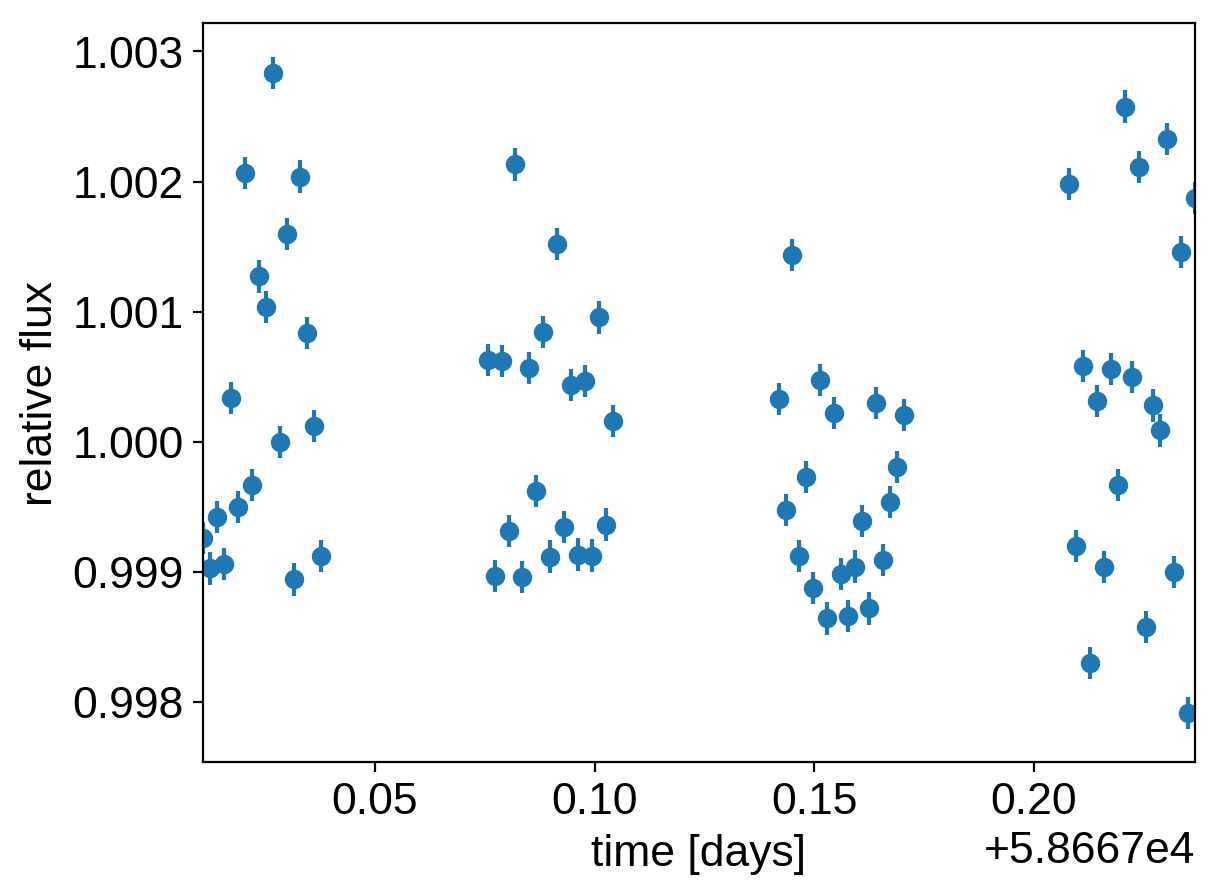

In [103]:
# Compute a limb-darkened light curve using starry
t = data_df['times']
u = []
flux = data_df['flux']
yerr = data_df['unc']
# Note: the `eval` is needed because this is using Theano in
# the background

plt.errorbar(t, flux, yerr, fmt='o', color="C0")
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [0]:
np.random.seed(42)

time_med = np.median(t)
med_t_diff = np.median(np.diff(t))

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [105]:
from multiprocessing import cpu_count
print(f'This instance has {cpu_count()} CPUs')

This instance has 4 CPUs


In [0]:
import pymc3 as pm
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]
t0 = time_med
edepth = np.sqrt(10/1e6)

orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=t).eval().flatten()

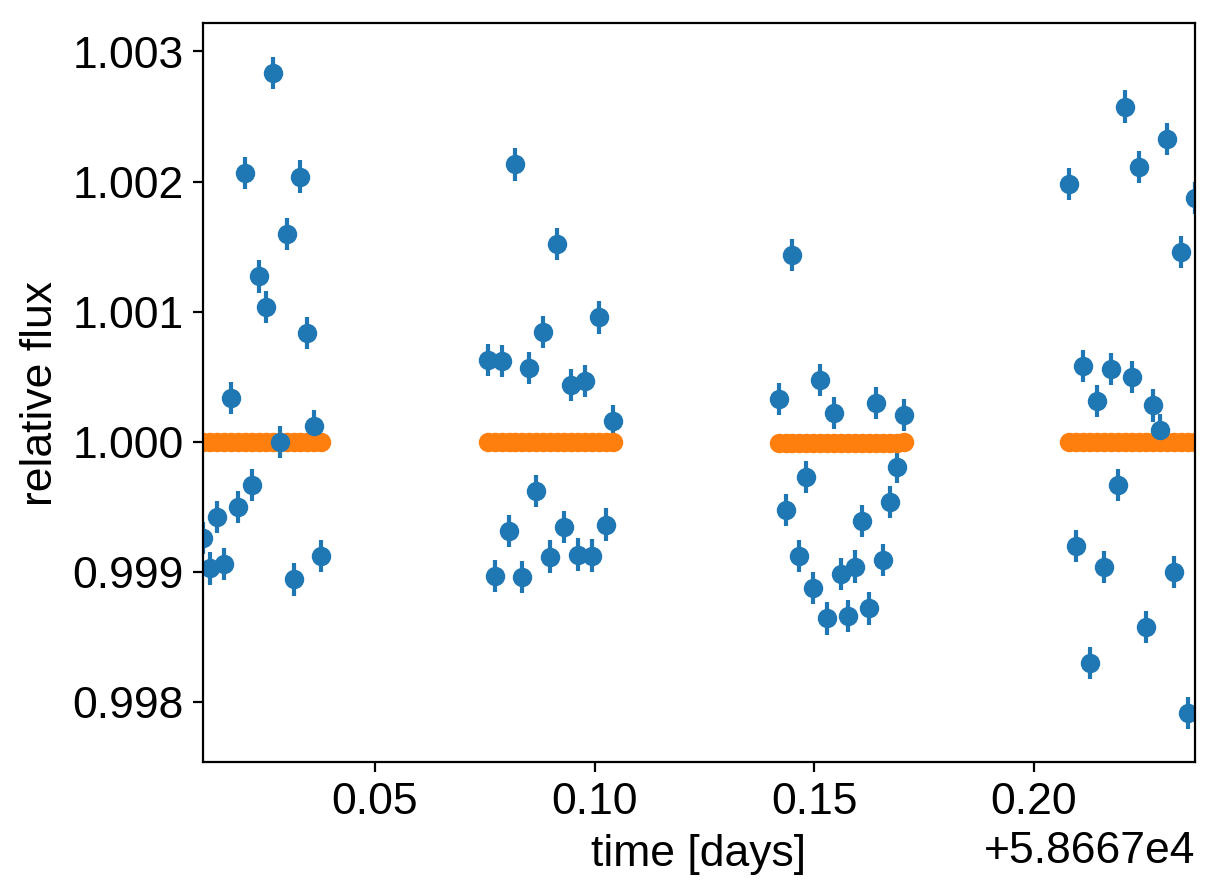

In [107]:
plt.errorbar(t, flux, yerr, fmt='o')
plt.plot(t, light_curves+1,'o')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

In [0]:
t0_wasp43 = 55528.3684
n_epochs = np.int(np.round(((time_med - t0_wasp43) / period)-0.5))
n_epochs, ((time_med - t0_wasp43) / period)
t0_guess = t0_wasp43 + (n_epochs+0.5) * period

# t0s = np.random.normal(t0_guess, 0.1*med_t_diff, size=2)
t0s = t0_guess

In [109]:
import pymc3 as pm
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1e-6)  # , shape=2)

    # The log period; also tracking the period itself
    # logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    # period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    # u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    edepth = pm.Uniform("edepth", lower=1e-6, upper=0.1)  # , shape=2)  #, testval=np.array([0.04, 0.06]))
    edepth = np.sqrt(edepth)
    # b = xo.distributions.ImpactParameter("b", ror=r, shape=2, testval=np.random.rand(2))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0s, b=b)

    # # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=t) # this crashes?
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # # Here we track the value of the model light curve for plotting
    # # purposes
    pm.Deterministic("light_curves", light_curves)

    # # In this line, we simulate the dataset that we will fit
    # # y = xo.eval_in_model(light_curve)
    # # y += yerr * np.random.randn(len(y))

    # # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=flux)

    # # Fit for the maximum a posteriori parameters given the simuated dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [edepth, t0, mean]
25it [00:00, 52.56it/s, logp=-2.286406e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1480895.2693623244 -> -2286.4056186124535


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

In [110]:
print(f"Found an eclipse of size {map_soln['edepth']*1e6:.0f} ppm at {map_soln['edepth']*86400:.2f} seconds from expected")

Found an eclipse of size 665 ppm at 57.49 seconds from expected


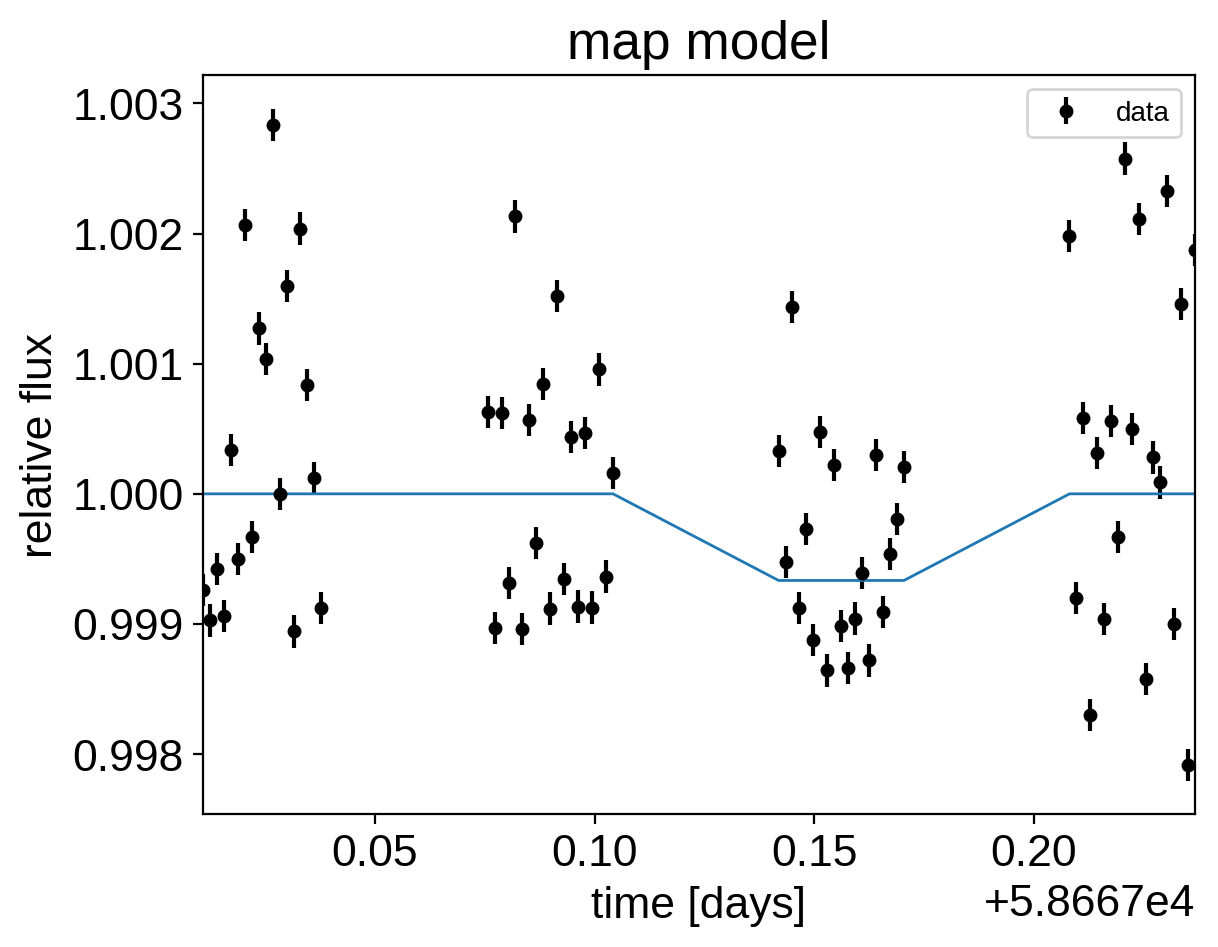

In [111]:
plt.errorbar(t, flux, yerr, color="k", fmt='o', ms=4, label="data")
plt.plot(t, map_soln["light_curves"]+1, lw=1)
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [112]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [edepth, t0, mean]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:49<00:00, 487.29draws/s]


After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [113]:
pm.summary(trace, varnames=["t0", "edepth", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
t0,58667.161688,0.000001,8.714754e-09,58667.161686,58667.161689,12204.271206,0.999859
edepth,0.000663,0.000033,2.878658e-07,0.000601,0.000729,12189.712336,0.999940
mean,1.000245,0.000017,1.586348e-07,1.000212,1.000276,11791.583955,0.999937


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

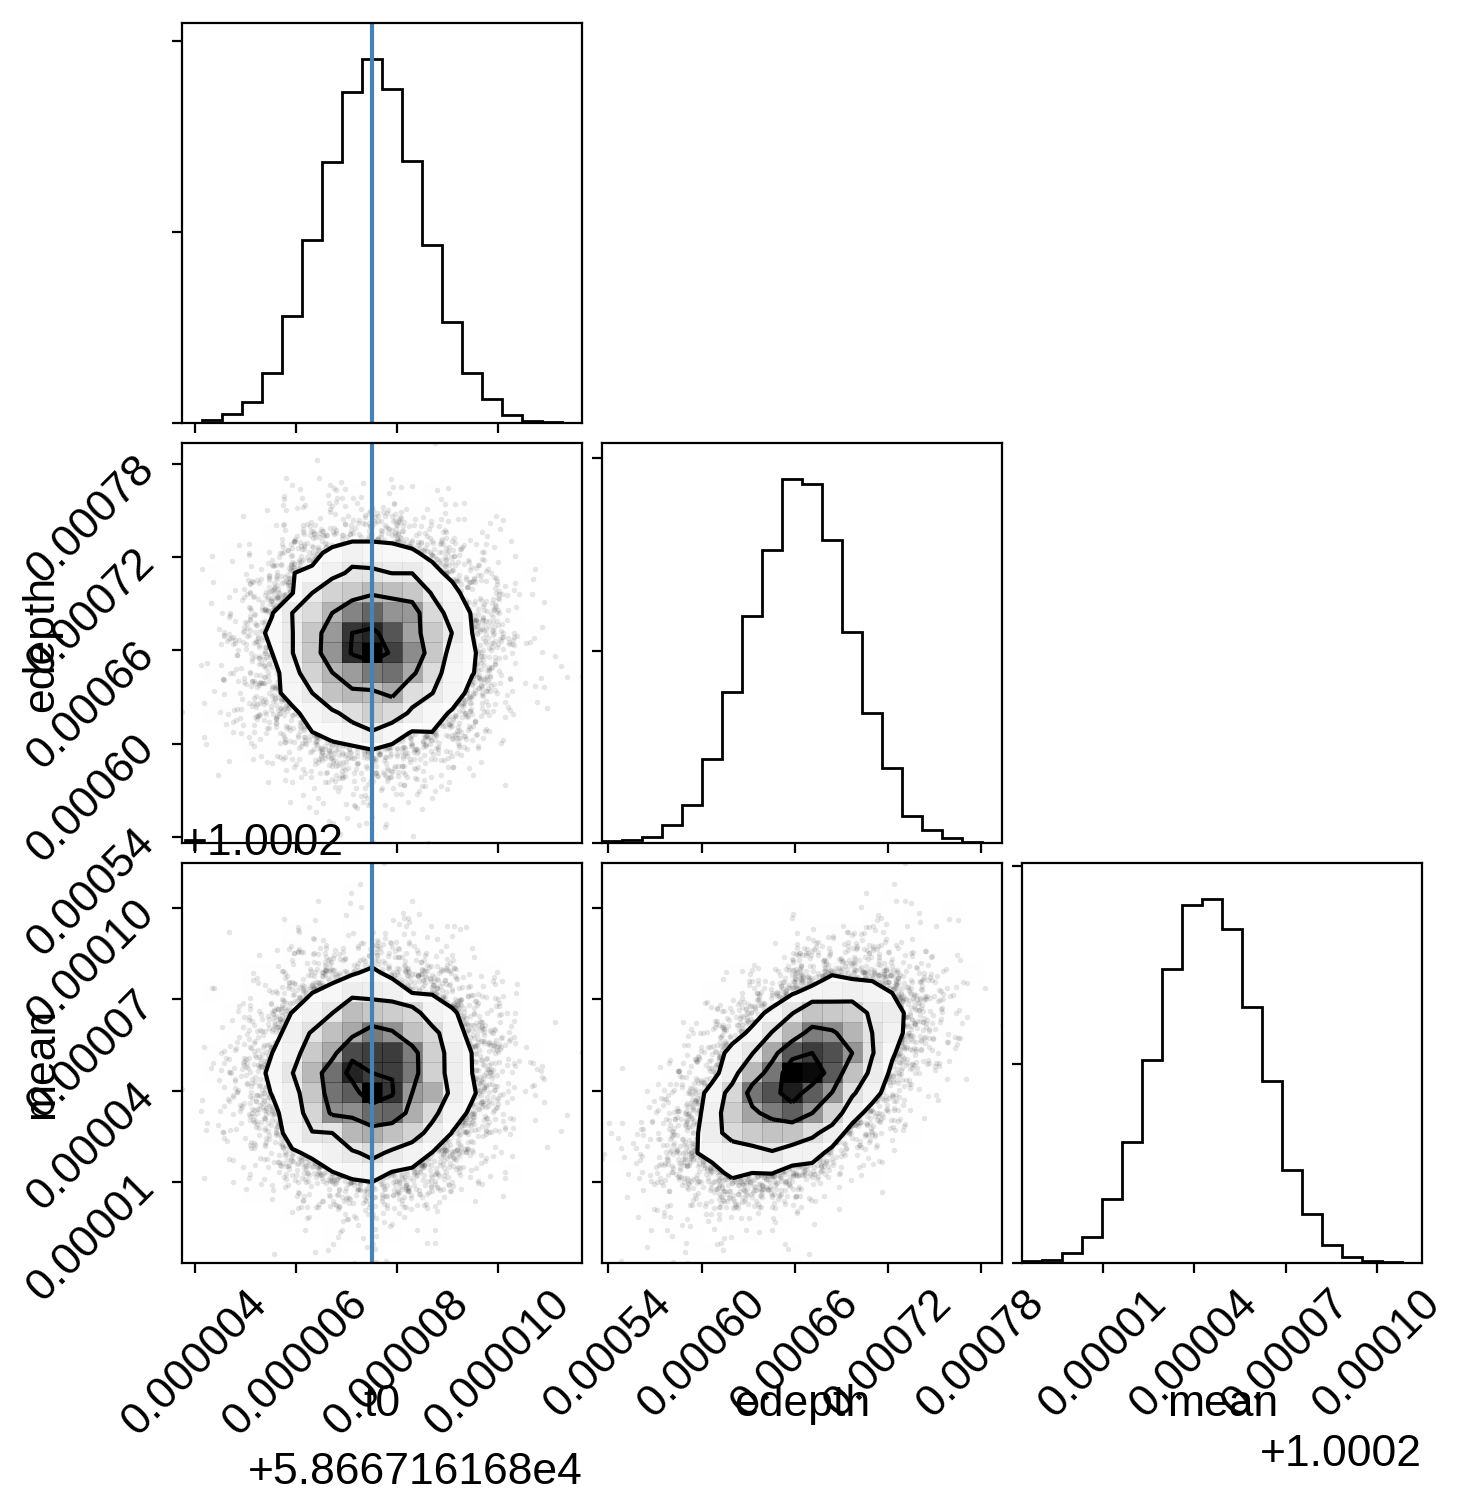

In [114]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["t0", "edepth", "mean"])
truth = [t0_guess, t0_guess, 0.0, 0.0, 1.0]
corner.corner(samples, truths=truth, labels=["t0", "edepth", "mean"]);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

Text(0.5, 1.0, 'WASP43 UVIS Eclipse')

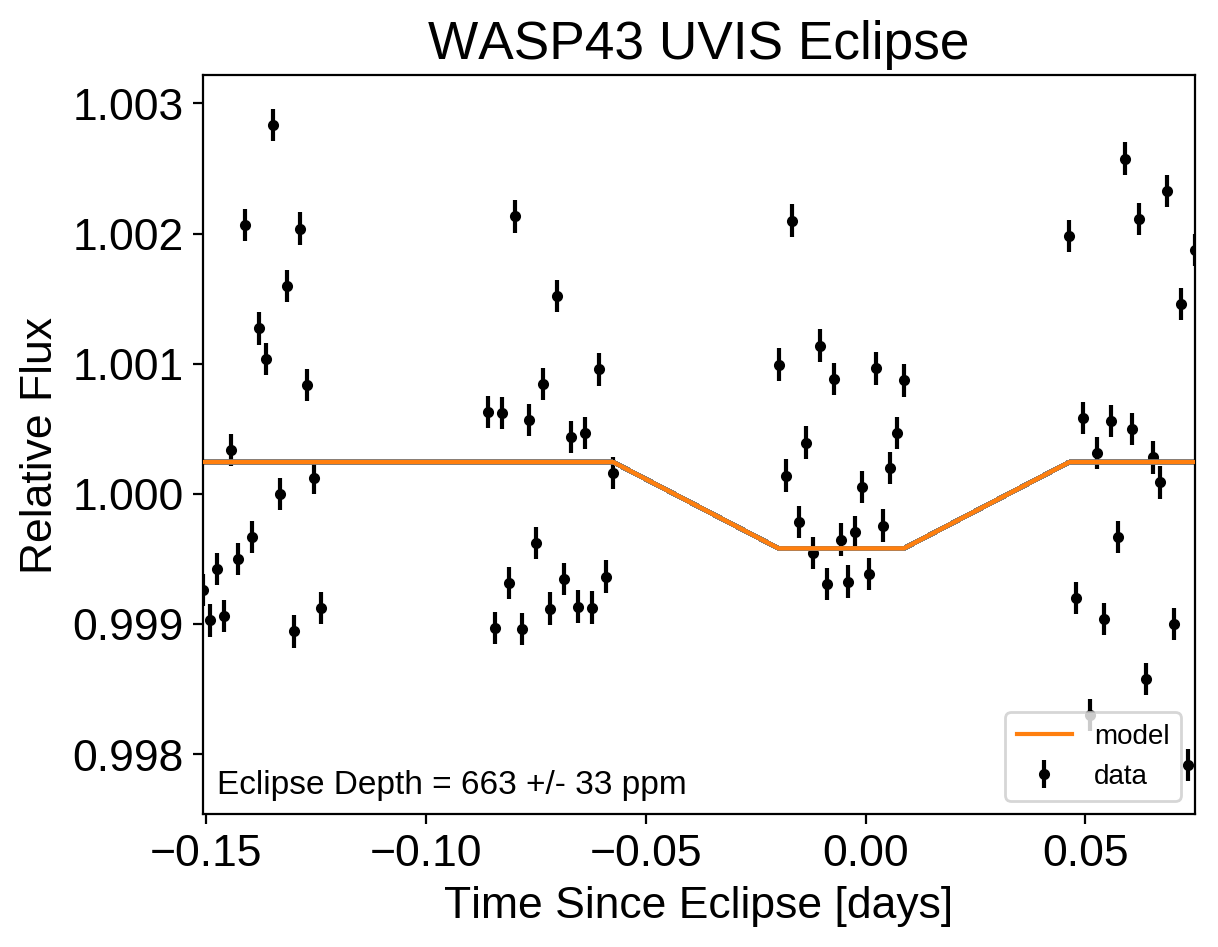

In [119]:
plt.figure()

# Get the posterior median orbital parameters
p = period
t0 = np.median(trace["t0"])

# Compute the median of posterior estimate of the contribution from
# the other planet. Then we can remove this from the data to plot
# just the planet we care about.
other = np.median(trace["light_curves"], axis=0).flatten()

# Plot the folded data
# x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
plt.errorbar(t - t0, flux - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

# Plot the folded model
# inds = np.argsort(x_fold)
# inds = inds[np.abs(x_fold)[inds] < 0.3]
preds = trace["light_curves"][:,:,0] + trace["mean"][:, None]
pred = np.median(preds, axis=0)
plt.plot(t - t0, pred, color="C1", label="model", zorder=10)

# Annotate the plot with the planet's period
txt = f"Eclipse Depth = {np.mean(trace["edepth"]*1e6):.0f} "\
        "+/- {np.std(trace["edepth"]*1e6):.0f} ppm"

plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

n_traces = 1000
idx_rand = np.random.choice(np.arange(preds.shape[0]), size=n_traces, replace=False)
for pred_ in preds[idx_rand]:
    plt.plot(t - t0, pred, color="grey", alpha=0.5, zorder=0)

plt.legend(fontsize=10, loc=4)
plt.xlim((t - t0).min(), (t - t0).max())
plt.xlabel("Time Since Eclipse [days]")
plt.ylabel("Relative Flux")
plt.title("WASP43 UVIS Eclipse")

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [116]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [117]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet},
   month = sep,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
